In [1]:
import sys
sys.executable

'/home/ingn/miniconda3/envs/micron2/bin/python'

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc

from micron2.spatial import (get_neighbors, categorical_neighbors, 
                             sliding_window_niches, k_neighbor_niches,
                             celltype_distances
                            )
from micron2.clustering import cluster_leiden, run_tsne, plot_embedding, cluster_leiden_cu

from statannot import add_stat_annotation
from itertools import combinations

from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
rcParams['figure.facecolor'] = (1,1,1,1)

In [2]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
# Remove filtered cells
adata = adata[adata.obs.sample_id != '210226_Bladder_TMA1_reg35_v5'].copy()
adata = adata[adata.obs.subtype_rescued!='filtered'].copy()

In [3]:
# adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
color_dict = {k:c for k,c in zip(np.unique(adata.obs.subtype), adata.uns['subtype_colors'])}
color_dict['Epithelial_KRT13_KRT17'] = '#6f0dba'
color_dict['Epithelial_KRT13'] = '#bcbd22'
color_dict['Epithelial_CDH'] = '#1f77b4'

# subtype_colors = {
#     'Epithelial_CDH':"#1f77b4",
#     'Epithelial_inter':"#2ca02c",
#     'Epithelial_prolif':"#d62728",
#     'Epithelial_KRT':"#bcbd22",
#     'Fibroblast':"#98df8a",
#     'Endothelial':"#17becf",
#     'Myeloid':"#aec7e8",
#     'Lymphocyte':"#e377c2"
# }

In [4]:
toss_1 = [f'TMA1_reg{x}.h5ad' for x in [2,3,4,6,11,16,17,21,22,23,24,27, 35]]
toss_2 = [f'TMA2_reg{x}.h5ad' for x in [2,10,21,22,26,34]]
toss_3 = [f'TMA3_reg{x}.h5ad' for x in [1,2,3,7,8,14,15,19,20,21,23,25,32,33]]
toss_patterns = toss_1 + toss_2 + toss_3
def maybe_keep(p):
    for r in toss_patterns:
        if r in p:
            return False
    return True

adata_paths = !ls /storage/codex/preprocessed_data/*Bladder*/*.h5ad
adata_paths = [p for p in adata_paths if maybe_keep(p)]
len(adata_paths)

75

In [5]:
# make a new column with KRT13 and 17 joined
subtype_2 = np.array(adata.obs.subtype)
subtype_2[subtype_2 == 'Epithelial_KRT13'] = 'Epithelial_KRT13_KRT17'
subtype_2[subtype_2 == 'Epithelial_KRT17'] = 'Epithelial_KRT13_KRT17'
adata.obs['subtype_2'] = pd.Categorical(subtype_2)

# Test with several neighborhood settings

In [6]:
import os
from itertools import product as it_prod
import pandas as pd
import tqdm.auto as tqdm
import copy

u_cells = [
    'Bcell',
    'Mac',
    'CD4T',
    'CD4T_Treg',
    'CD8T',
    'CD8T_Trm',
    'CD8T_activated',
    'CD8T_exhausted',
    'Epithelial',
    'Epithelial_KRT13_KRT17',
    'Epithelial_CDH',
#     'Epithelial_KRT13',
#     'Epithelial_KRT17',
    'Stromal'
]

min_cells = 25

cellular_distances_k = {}
for k in [1,5,10]:
    cellular_distances_k[k] = {}
    
    with tqdm.tqdm(adata_paths) as pbar:
        for pth in pbar:
            sample = os.path.basename(pth).replace('.h5ad','')
            ad = sc.read_h5ad(pth)
            
            # make a new column with KRT13 and 17 joined
            subtype_2 = np.array(ad.obs.subtype)
            subtype_2[subtype_2 == 'Epithelial_KRT13'] = 'Epithelial_KRT13_KRT17'
            subtype_2[subtype_2 == 'Epithelial_KRT17'] = 'Epithelial_KRT13_KRT17'
            ad.obs['subtype_2'] = pd.Categorical(subtype_2)
            
            pbar.set_description(f'{sample}: {ad.shape}')
            coords = ad.obsm['coordinates'].astype(np.float32)
            celltypes = np.array(ad.obs.subtype_2)

            dists = pd.DataFrame(index=u_cells, columns=u_cells, dtype=np.float32)
            for c1,c2 in it_prod(u_cells,u_cells):
                if c1==c2: 
                    continue
                if (np.sum(celltypes==c1)<min_cells) or (np.sum(celltypes==c2)<min_cells):
                    continue
                d = celltype_distances(coords, celltypes, c1, c2, k=k, mode='k-nearest', 
                                       summary_fn=np.mean)
                dists.loc[c1,c2] = np.median(d)
            cellular_distances_k[k][sample] = dists.copy()
            

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

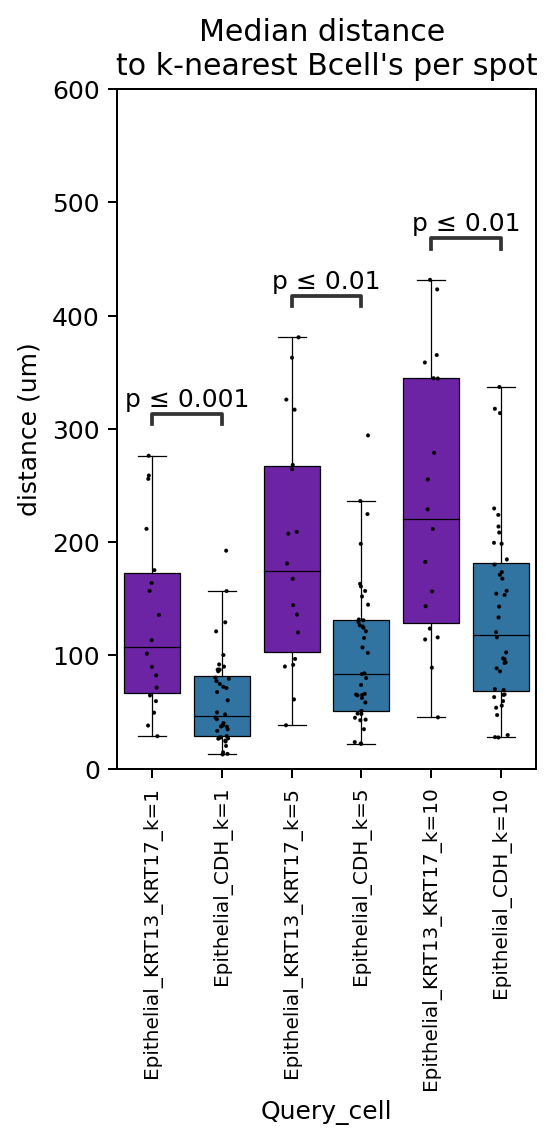

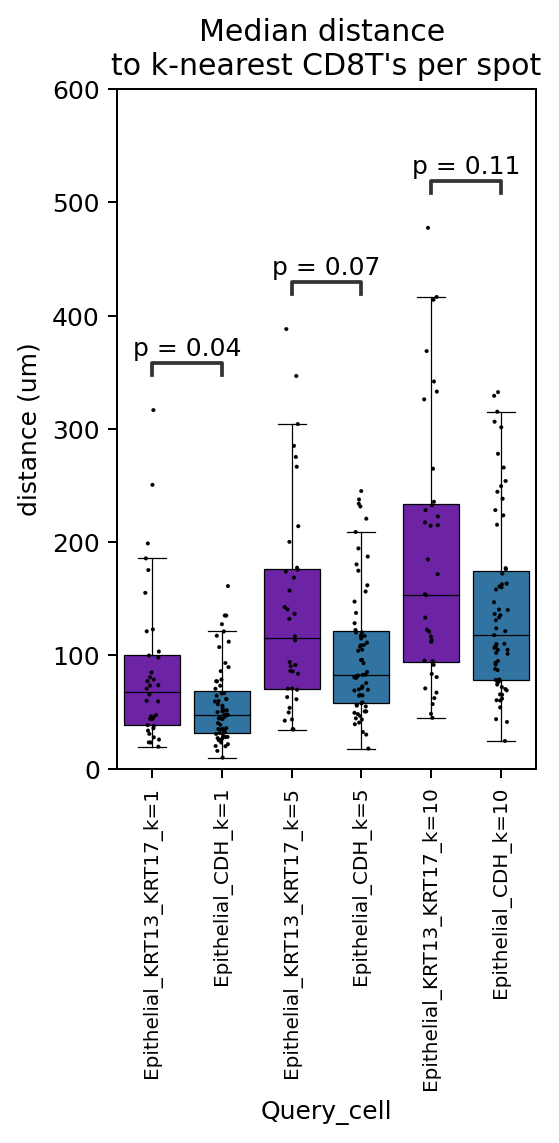

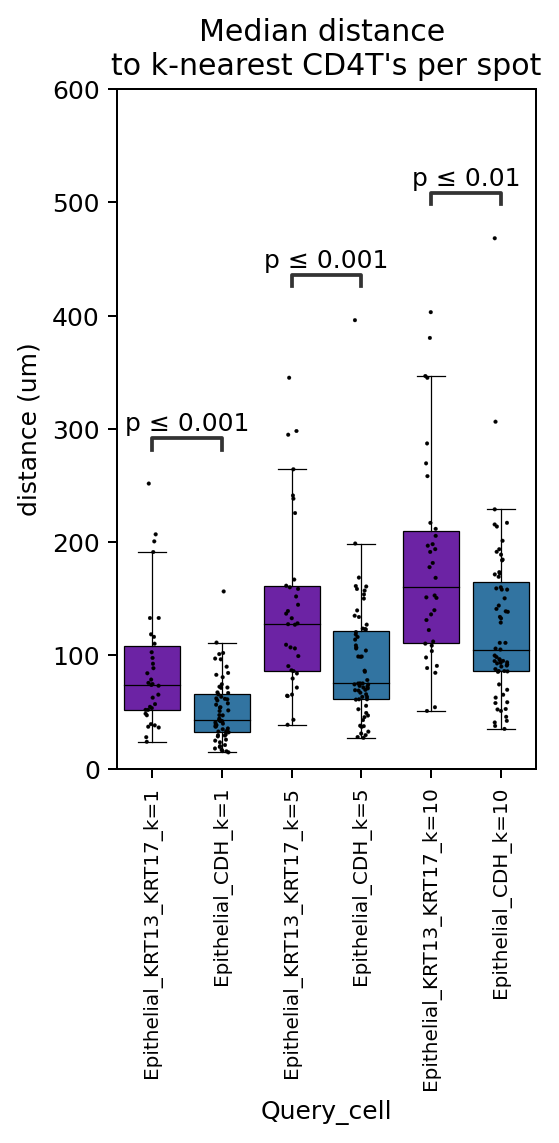

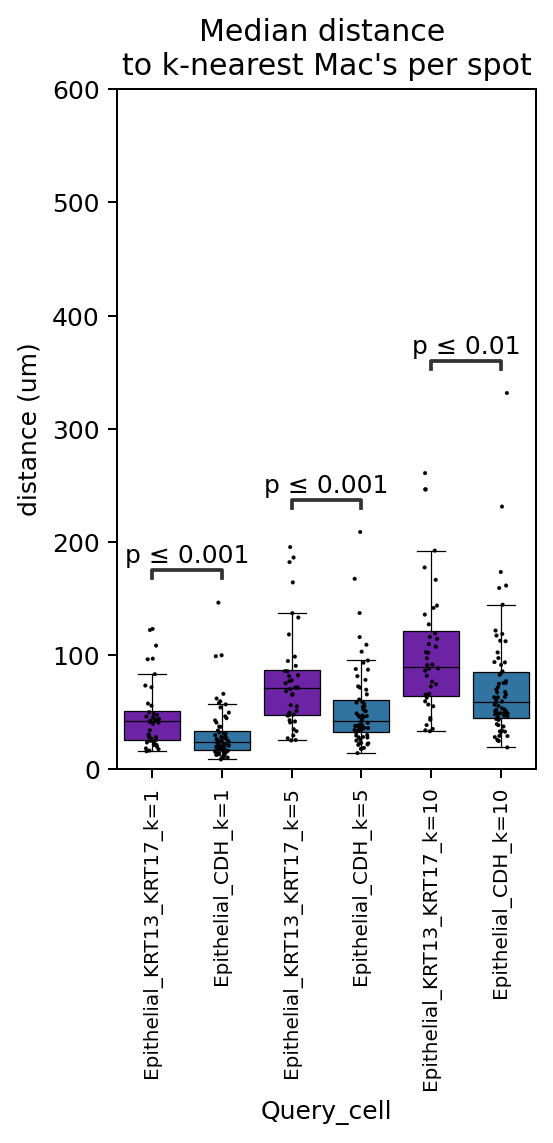

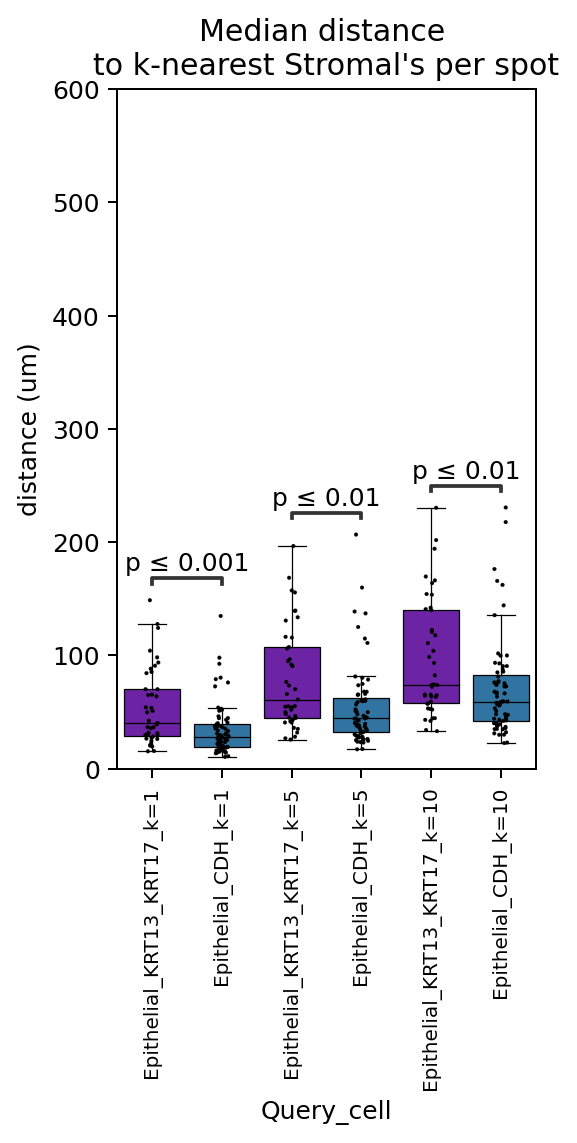

In [7]:
rcParams['figure.facecolor'] = (1,1,1,1)

# fig, axs = plt.subplots(2,4, figsize=(18, 12), dpi=90, gridspec_kw=dict(hspace=0.5))
# axs = axs.ravel()

kvals = [1,5,10]
ts = ['Bcell', 'CD8T', 'CD4T', 'Mac', 'Stromal']

for t in ts:

    plt.figure(figsize=(3,5), dpi=180)
    ax = plt.gca()

    ds = []
    samples = []
    queries = []
    targets = []
    colors = {}

    qs = ['Epithelial_KRT13_KRT17', 'Epithelial_CDH']
    order = []
    for k in kvals:
        order += [f'{q}_k={k}' for q in qs]
    
    for q in qs:
        for kval in kvals:
            vals = []
            cellular_distances = cellular_distances_k[kval]
            for k,v in cellular_distances.items():
                z = v.loc[q,t]
                if np.isnan(z):
                    continue
                z = z * 0.325
                #ds.append(np.log10(z))
                ds.append(z)
                samples.append(k)
                queries.append(q+f'_k={kval}')
                targets.append(t)
                colors[q+f'_k={kval}'] = color_dict[q]

    data = {'Distances': ds,
            'Samples': samples,
            'Query_cell': queries,
            'Target_cell': targets,
    #         'color': colors
           }
    distances = pd.DataFrame( data )

    #     plt.figure(figsize=(3,3), dpi=90)
    #     ax = plt.gca()
    sns.boxplot(data=distances, x='Query_cell', y='Distances', ax=ax, color='w', 
                order=order,
                palette=colors, fliersize=0, linewidth=0.5)
    sns.stripplot(data=distances, x='Query_cell', y='Distances', color='k', ax=ax, 
                  #palette=colors,
                  order=order,
                  s=1.5,
                  linewidth=0.1, 
                  edgecolor='k')

    _ = add_stat_annotation(data=distances, x='Query_cell', y='Distances', ax=ax, order=order,
                            box_pairs=[] +\
                                [(f'Epithelial_KRT13_KRT17_k={kv}', f'Epithelial_CDH_k={kv}') for kv in [1,5,10]],
#                                 [(f'Epithelial_KRT13_k={kv}', f'Epithelial_KRT17_k={kv}') for kv in [1,5,10]] +\
#                                 [(f'Epithelial_KRT17_k={kv}', f'Epithelial_CDH_k={kv}') for kv in [1,5,10]] +\
#                                 [(f'Epithelial_KRT13_k={kv}', f'Epithelial_CDH_k={kv}') for kv in [1,5,10]],
                            text_format='simple',
                            test='Mann-Whitney',
                            comparisons_correction=None,
                            verbose=False,
                           )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)

#     ax.set_ylabel('log distance (pixels)')
    ax.set_ylabel('distance (um)')
    ax.set_title(f"Median distance \nto k-nearest {t}'s per spot")

    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
                
    ax.set_ylim([0, 600])
    plt.savefig(f'figures/{t}_median_dist.svg', bbox_inches='tight')
                
